In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scanpy.plotting
import seaborn as sns
import warnings
from _utils import *
import stadiffuser.utils as stu
warnings.filterwarnings("ignore")
sns.set_context("paper", font_scale=1.5)
output_root = "../output/App3-Xenium-BRCA"
output_figdir = os.path.join(output_root, "_figures")

In [2]:
adata = sc.read_10x_h5("../dataset/xenium/Xenium_FFPE_Human_Breast_Cancer_Rep1_cell_feature_matrix.h5")
df_annotation = pd.read_csv("../dataset/xenium/GSM7780153_Xenium_R1_Fig1-5_supervised.csv", index_col=0)
# set the index to integer
df_annotation.index = df_annotation.index.astype(int).astype(str)
df = pd.read_csv("../dataset/xenium/Xenium_FFPE_Human_Breast_Cancer_Rep1_cells.csv.gz", index_col=0)
df.set_index(adata.obs_names, inplace=True)
# match the annotation with the data by index
df = df.join(df_annotation, how="left")
adata.obs = df
adata.obs_names = df.index
adata.var_names_make_unique()
na_index = adata.obs["Cluster"].isna()
adata = adata[~na_index].copy()
# copy and subeset the adata by ~na_index
# count the number of cells in each cluster
spatial = adata.obs[["x_centroid", "y_centroid"]].copy()
adata.obsm["spatial"] = spatial
# remove the redundant columns in obs
adata.obs.drop(columns=["x_centroid", "y_centroid"], inplace=True)
adata.obsm["spatial"] = np.array(spatial)

In [3]:
# calculate the quality control metrics
sc.pp.calculate_qc_metrics(adata, percent_top=(10, 20, 50, 150), inplace=True)
cprobes = (
    adata.obs["control_probe_counts"].sum() / adata.obs["total_counts"].sum() * 100
)
cwords = (
    adata.obs["control_codeword_counts"].sum() / adata.obs["total_counts"].sum() * 100
)
print(f"Negative DNA probe count % : {cprobes}")
print(f"Negative decoding count % : {cwords}")

Negative DNA probe count % : 0.0870099032138346
Negative decoding count % : 0.005482562802895433


In [4]:
sc.pp.filter_cells(adata, min_counts=10)
sc.pp.filter_genes(adata, min_cells=5)
# save the raw data to disk
adata.write_h5ad(f"{output_root}/adata_raw.h5ad")

In [9]:
# load the raw data
adata = sc.read_h5ad(f"{output_root}/adata_raw.h5ad")
sc.pp.log1p(adata)

In [10]:
# save the normalized data to disk
adata = stu.cal_spatial_net2D(adata, rad_cutoff=1)
adata.write_h5ad(f"{output_root}/adata_processed.h5ad")

------Calculating spatial graph...
------Spatial graph calculated.
The graph contains 0 edges, 164077 cells, 0.0000 neighbors per cell on average.


In [11]:
# save to disk
adata.write_h5ad(f"{output_root}/adata_processed.h5ad")

# Visualize data

In [12]:
import importlib
from stadiffuser import pipeline

In [13]:
device = "cuda:0"
ckpt = [100, 200, 300, 400]
adata = sc.read_h5ad(f"{output_root}/adata_processed.h5ad")

Processing checkpoint:  100


  0%|          | 0/641 [00:00<?, ?it/s]

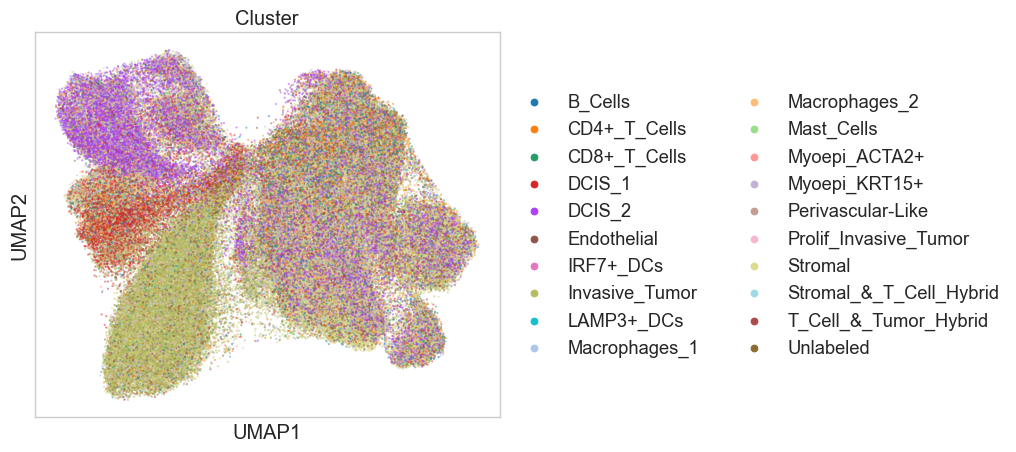

Processing checkpoint:  200


  0%|          | 0/641 [00:00<?, ?it/s]

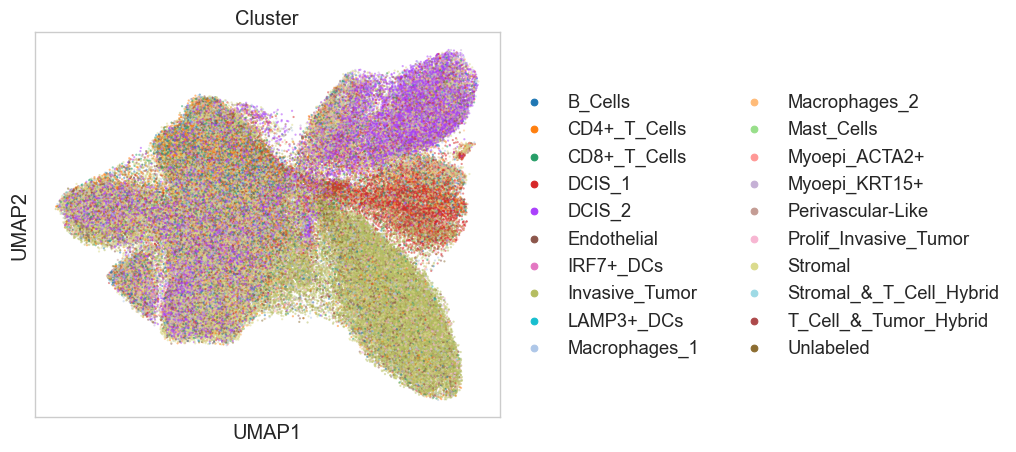

Processing checkpoint:  300


  0%|          | 0/641 [00:00<?, ?it/s]

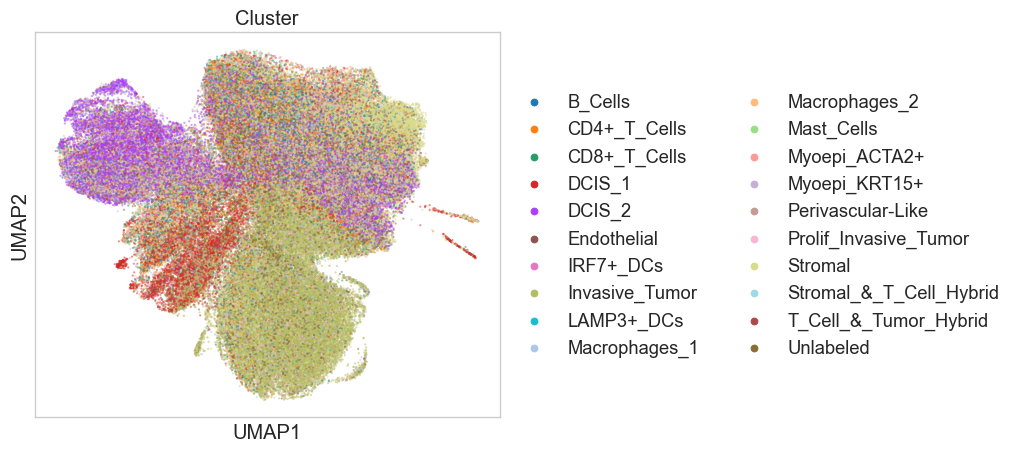

Processing checkpoint:  400


  0%|          | 0/641 [00:00<?, ?it/s]

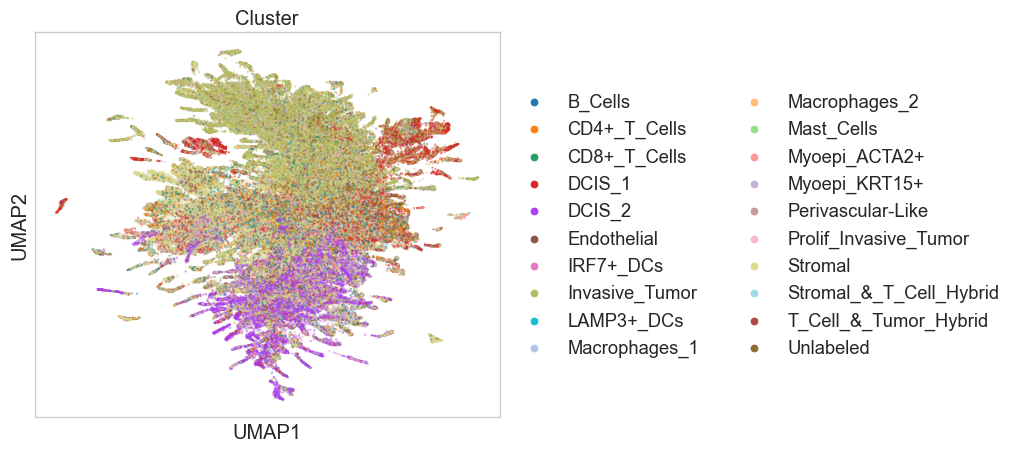

In [14]:
for i in ckpt:
    print("Processing checkpoint: ", i)
    autoencoder = torch.load(f"{output_root}/autoencoder_attn2_{i}.pth").to(device)
    adata = pipeline.get_recon(adata, autoencoder, "cuda:0", apply_normalize=False, batch_mode=True)
    # umap
    sc.pp.neighbors(adata, n_neighbors=30, use_rep="latent")
    sc.tl.umap(adata, min_dist=0.5)
    fig, ax = plt.subplots(1, 1, figsize=(6, 5))
    sc.pl.umap(adata, color="Cluster", s=10, alpha=0.5, ax=ax)
    fig.savefig(os.path.join(output_figdir, f"umap_{i}.png"), dpi=300)

In [31]:
from scipy import stats
y = np.array([11, 8, 4])
x = np.array([347, 313, 230])
# fit the line using linear regression in numpy
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y * 5)
print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
print(f"R2: {r_value**2}")

Slope: 0.2882580288948192
Intercept: -47.18321523879637
R2: 0.9761819194735365


In [23]:
y / 100 * 200

array([22., 16.,  8.])